In [53]:
from IPython.display import Image

In [54]:
Image(url='https://raw.githubusercontent.com/rickiepark/ml-with-pytorch/main/ch13/figures/13_01.png', width=400)

파이토치로 구현

In [55]:
import torch

In [56]:
def compute_z(a, b, c):
  r1 = torch.sub(a,b)
  r2 = torch.mul(r1,2)
  z = torch.add(r2,c)
  return z

In [57]:
a,b,c = torch.tensor(1),torch.tensor(2), torch.tensor(3)
print("스칼라 입력 : ",  compute_z(a,b,c) )
a,b,c = torch.tensor([1]),torch.tensor([2]), torch.tensor([3])
print("랭크 1 입력 : ",  compute_z(a,b,c) )
a,b,c = torch.tensor([[1]]),torch.tensor([[2]]), torch.tensor([[3]])
print("랭크 2 입력 : ",  compute_z(a,b,c) )

스칼라 입력 :  tensor(1)
랭크 1 입력 :  tensor([1])
랭크 2 입력 :  tensor([[1]])


In [58]:
a = torch.tensor(3.14, requires_grad=True)
b = torch.tensor([1.0, 2.0, 3.0], requires_grad=True)
print(a)
print(b)

tensor(3.1400, requires_grad=True)
tensor([1., 2., 3.], requires_grad=True)


In [59]:
a.requires_grad

True

In [60]:
w = torch.tensor([1.0, 2.0, 3.0])
w.requires_grad

False

In [61]:
w.requires_grad_()  # 그레이드 적용
w.requires_grad

True

In [62]:
import torch.nn as nn
torch.manual_seed(1)
w = torch.empty(2,3)
print(w)
nn.init.xavier_normal_(w)  # xavier초기화를 적용해서 w의 값을 초기화  , xavier초기화는 신경망의 가중치를 적절하게 초기화해서 그레이디언트의 전파를 개선
print(w)

tensor([[1.3016e+13, 3.2929e-41, 1.9246e+13],
        [3.2929e-41, 8.9683e-44, 0.0000e+00]])
tensor([[ 0.4183,  0.1688,  0.0390],
        [ 0.3930, -0.2858, -0.1051]])


In [63]:
class MyModule(nn.Module):
  def __init__(self):
    self.w1 = torch.empty(2,3, requires_grad=True)
    nn.init.xavier_normal_(self.w1)
    self.w2 = torch.empty(1,2, requires_grad=True)
    nn.init.xavier_normal_(self.w2)

자동 미분으로 그레이디언트 계산

In [64]:
w = torch.tensor(1.0, requires_grad=True)
b = torch.tensor(0.5, requires_grad=True)

x = torch.tensor([1.4])
y = torch.tensor([2.1])

z = torch.add(torch.mul(w,x), b)

loss = (y- z).pow(2).sum()
loss.backward()

print("dL/dW :",w.grad)
print("dL/db :",b.grad)

dL/dW : tensor(-0.5600)
dL/db : tensor(-0.4000)


In [65]:
2*x*((w*x+b) - y)

tensor([-0.5600], grad_fn=<MulBackward0>)

torch.nn 모듈을 사용해서 일반적인 아키텍처 구현
  - nn.Sequential 기반의 모델 구현

In [66]:
model = nn.Sequential(
    nn.Linear(4,6),
    nn.ReLU(),
    nn.Linear(16,32),
    nn.ReLU()
)
model

Sequential(
  (0): Linear(in_features=4, out_features=6, bias=True)
  (1): ReLU()
  (2): Linear(in_features=16, out_features=32, bias=True)
  (3): ReLU()
)

In [67]:
nn.init.xavier_normal(model[0].weight)

l1_weight = 0.01
l1_panalty = l1_weight * model[2].weight.abs().sum()

<ipython-input-67-5792c52d9d24>:1: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  nn.init.xavier_normal(model[0].weight)


In [68]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

XOR 분류 문제 풀기

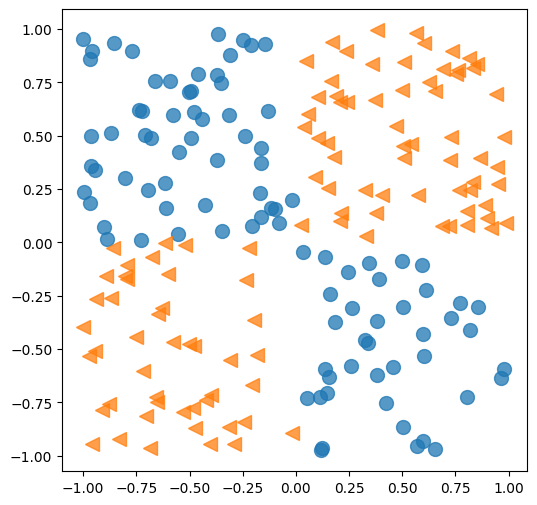

In [69]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(1)
torch.manual_seed(1)
x = np.random.uniform(low=-1, high=1, size=(200,2))
y = np.ones(len(x))
y[ x[:,0] * x[:,1]<0  ] = 0

n_train = 100
x_train = torch.tensor( x[:n_train, : ], dtype = torch.float32 )
y_train = torch.tensor( y[:n_train], dtype=torch.float32)
x_valid = torch.tensor( x[n_train:, :], dtype=torch.float32)
y_valid = torch.tensor( y[n_train:], dtype=torch.float32)

fig = plt.figure(figsize=(6,6))
plt.plot(x[y==0, 0], x[y==0, 1], 'o', alpha=0.75 ,markersize=10)
plt.plot(x[y==1, 0], x[y==1, 1], '<', alpha=0.75 ,markersize=10)

plt.show()

In [70]:
from torch.utils.data import DataLoader, TensorDataset
train_ds = TensorDataset(x_train, y_train)
batch_size = 2
torch.manual_seed(1)
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

In [71]:
model = nn.Sequential(
    nn.Linear(2,1),
    nn.Sigmoid()
)
model

Sequential(
  (0): Linear(in_features=2, out_features=1, bias=True)
  (1): Sigmoid()
)

In [72]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

In [73]:
torch.manual_seed(1)
num_epochs = 200
def train(model, num_epochs, train_dl, x_valid, y_valid):
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs
    for epoch in range(num_epochs):
        for x_batch, y_batch in train_dl:
            pred = model(x_batch)[:, 0]
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_hist_train[epoch] += loss.item()
            is_correct = ((pred>=0.5).float() == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.mean()

        loss_hist_train[epoch] /= n_train/batch_size
        accuracy_hist_train[epoch] /= n_train/batch_size

        pred = model(x_valid)[:, 0]
        loss = loss_fn(pred, y_valid)
        loss_hist_valid[epoch] = loss.item()
        is_correct = ((pred>=0.5).float() == y_valid).float()
        accuracy_hist_valid[epoch] += is_correct.mean()
    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid

history = train(model, num_epochs, train_dl, x_valid, y_valid)

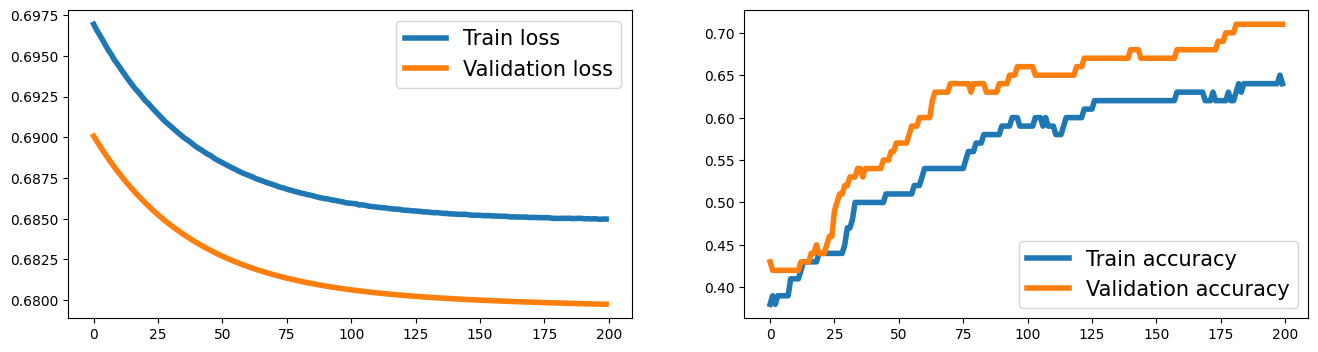

In [74]:
fig = plt.figure(figsize = (16,4))
ax = fig.add_subplot(1,2,1)
plt.plot(history[0], lw=4,label='Train loss')
plt.plot(history[1], lw=4, label='Validation loss')
plt.legend(fontsize=15)

ax = fig.add_subplot(1,2,2)
plt.plot(history[2], lw=4,label='Train accuracy')
plt.plot(history[3], lw=4, label='Validation accuracy')
plt.legend(fontsize=15)

In [77]:
model = nn.Sequential(
    nn.Linear(2,4),
    nn.ReLU(),
    nn.Linear(4,4),
    nn.ReLU(),
    nn.Linear(4,1),
    nn.Sigmoid()
)
loss_fn = nn.BCELoss()
optimizer=torch.optim.SGD(model.parameters(), lr=0.015)
model

Sequential(
  (0): Linear(in_features=2, out_features=4, bias=True)
  (1): ReLU()
  (2): Linear(in_features=4, out_features=4, bias=True)
  (3): ReLU()
  (4): Linear(in_features=4, out_features=1, bias=True)
  (5): Sigmoid()
)

In [78]:
history = train(model, num_epochs, train_dl, x_valid, y_valid)

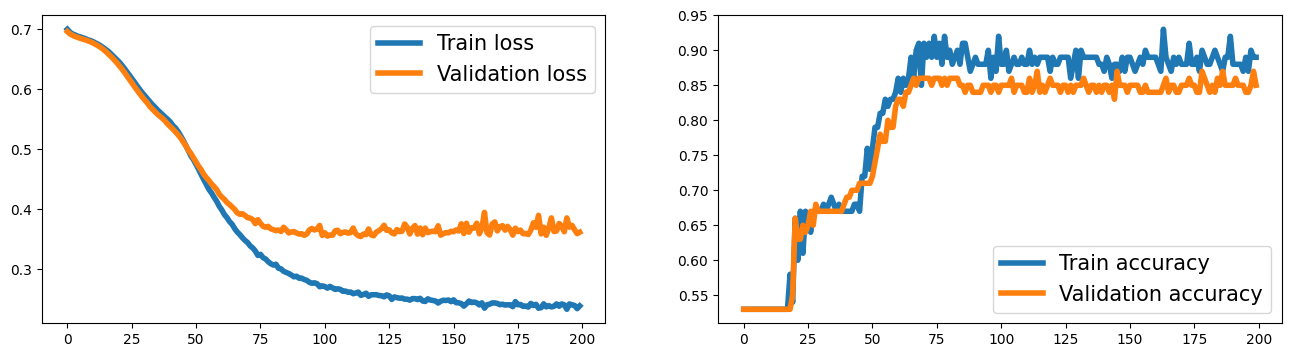

In [79]:
fig = plt.figure(figsize = (16,4))
ax = fig.add_subplot(1,2,1)
plt.plot(history[0], lw=4,label='Train loss')
plt.plot(history[1], lw=4, label='Validation loss')
plt.legend(fontsize=15)

ax = fig.add_subplot(1,2,2)
plt.plot(history[2], lw=4,label='Train accuracy')
plt.plot(history[3], lw=4, label='Validation accuracy')
plt.legend(fontsize=15)

nn.Module 로 유연성이 높은 모델 만들기

In [84]:
class MyModule(nn.Module):
  def __init__(self):
    super().__init__()

    l1 = nn.Linear(2,4)
    a1 = nn.ReLU()
    l2 = nn.Linear(4,4)
    a2 = nn.ReLU()
    l3 = nn.Linear(4,1)
    a3 = nn.Sigmoid()
    list_ = [l1,a1,l2,a2,l3,a3]
    self.module_list = nn.ModuleList(list_)
  def forward(self, x):
    for f in self.module_list:
      x = f(x)
    return x
  def predict(self,x):
    x = torch.tensor(x, dtype=torch.float32)
    pred = self.forward(x)[:,0]
    return (pred>=0.5).float()

model = MyModule()
model

MyModule(
  (module_list): ModuleList(
    (0): Linear(in_features=2, out_features=4, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4, out_features=4, bias=True)
    (3): ReLU()
    (4): Linear(in_features=4, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

In [85]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.015)

history = train(model, num_epochs, train_dl, x_valid, y_valid)

In [86]:
!pip install mlxtend

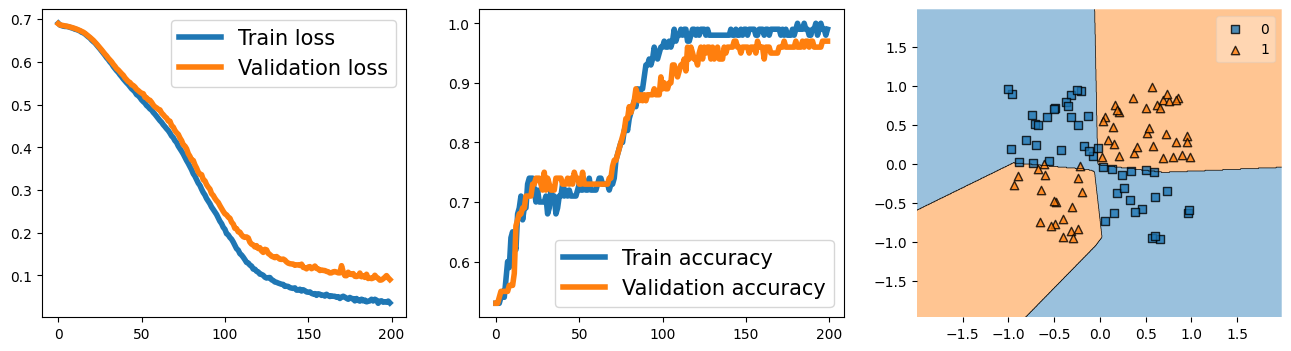

In [87]:
from mlxtend.plotting import plot_decision_regions
fig = plt.figure(figsize = (16,4))
ax = fig.add_subplot(1,3,1)
plt.plot(history[0], lw=4,label='Train loss')
plt.plot(history[1], lw=4, label='Validation loss')
plt.legend(fontsize=15)

ax = fig.add_subplot(1,3,2)
plt.plot(history[2], lw=4,label='Train accuracy')
plt.plot(history[3], lw=4, label='Validation accuracy')
plt.legend(fontsize=15)

ax = fig.add_subplot(1,3,3)
plot_decision_regions(X=x_valid.numpy(), y=y_valid.numpy().astype(np.int64), clf = model)
plt.show()

파이토치에서 사용자 정의 층 만들기

In [93]:
# 가우시안 노이즈를 포함하는 완전 연결층
# 모델의 일반화 성능을 높이고 오버피팅을 방지하는데 도움을 준다
class NoisyLinear(nn.Module):
  def __init__(self,input_size, output_size, noise_stddev = 0.1):
    super().__init__()
    w = torch.Tensor(input_size, output_size)
    self.w = nn.Parameter(w)
    nn.init.xavier_uniform_(self.w)
    b = torch.Tensor(output_size).fill_(0)
    self.b = nn.Parameter(b)
    self.noise_stddev = noise_stddev
  def forward(self,x, traning=False):
    if traning:
      noise = torch.normal(0.0, self.noise_stddev, x.shape)
      x_new = torch.add(x, noise)
    else:
      x_new = x
    return torch.add(torch.mm(x_new, self.w), self.b)

In [94]:
# 테스트
torch.manual_seed(1)
noisy_layer = NoisyLinear(4,2)
x = torch.zeros((1,4))
print(noisy_layer(x, traning=True))
print(noisy_layer(x, traning=True))
print(noisy_layer(x, traning=False))

tensor([[ 0.1154, -0.0598]], grad_fn=<AddBackward0>)
tensor([[ 0.0432, -0.0375]], grad_fn=<AddBackward0>)
tensor([[0., 0.]], grad_fn=<AddBackward0>)


In [95]:
class MyNoisyModule(nn.Module):
  def __init__(self):
    super().__init__()
    self.l1 = NoisyLinear(2,4,0.07)
    self.a1 = nn.ReLU()
    self.l2 = nn.Linear(4,4)
    self.a2 = nn.ReLU()
    self.l3 = nn.Linear(4,1)
    self.a3 = nn.Sigmoid()
  def forward(self,x,training=False):
    x = self.l1(x,training)
    x = self.a1(x)
    x = self.l2(x)
    x = self.a2(x)
    x = self.l3(x)
    x = self.a3(x)
    return x
  def predict(self, x):
    x = torch.tensor(x, dtype=torch.float32)
    pred = self.forward(x)[:,0]
    return (pred>=0.5).float()
torch.manual_seed(1)
model = MyNoisyModule()
model


MyNoisyModule(
  (l1): NoisyLinear()
  (a1): ReLU()
  (l2): Linear(in_features=4, out_features=4, bias=True)
  (a2): ReLU()
  (l3): Linear(in_features=4, out_features=1, bias=True)
  (a3): Sigmoid()
)

In [96]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.015)
torch.manual_seed(1)

loss_hist_train = [0]*num_epochs
accuracy_hist_train = [0]*num_epochs
loss_hist_valid = [0]*num_epochs
accuracy_hist_valid = [0]*num_epochs
for epoch in range(num_epochs):
  for x_batch,y_batch in train_dl:
    pred = model(x_batch, True)[:, 0]
    loss = loss_fn(pred, y_batch)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    loss_hist_train[epoch] += loss.item()
    is_correct = ( (pred>=0.5).float() == y_batch ).float()
    accuracy_hist_train[epoch] += is_correct.mean()
  loss_hist_train[epoch] /= n_train/batch_size
  accuracy_hist_train[epoch] /= n_train/batch_size

  pred = model(x_valid)[:, 0]
  loss = loss_fn(pred, y_valid)
  loss_hist_valid[epoch] = loss.item()
  is_correct = ((pred>=0.5).float() == y_valid).float()
  accuracy_hist_valid[epoch] += is_correct.mean()

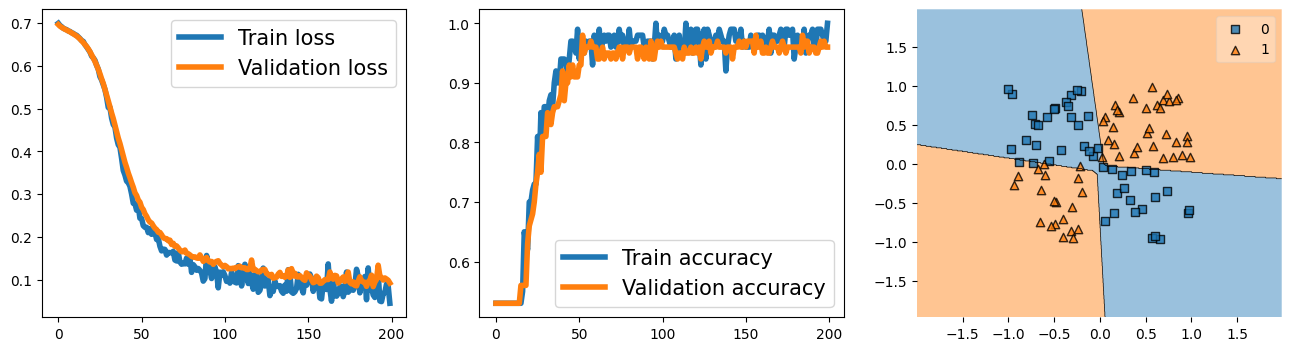

In [97]:
from mlxtend.plotting import plot_decision_regions
fig = plt.figure(figsize = (16,4))
ax = fig.add_subplot(1,3,1)
plt.plot(loss_hist_train, lw=4,label='Train loss')
plt.plot(loss_hist_valid, lw=4, label='Validation loss')
plt.legend(fontsize=15)

ax = fig.add_subplot(1,3,2)
plt.plot(accuracy_hist_train, lw=4,label='Train accuracy')
plt.plot(accuracy_hist_valid, lw=4, label='Validation accuracy')
plt.legend(fontsize=15)

ax = fig.add_subplot(1,3,3)
plot_decision_regions(X=x_valid.numpy(), y=y_valid.numpy().astype(np.int64), clf = model)
plt.show()